# Overview:
- Santander Bank(Spanish branch) is dedicated to enhancing its customer service by providing targeted financial product recommendations. As the financial journey of every individual varies, personalized financial advice and product offerings are crucial. For example, a person taking a home loan for the first time and another customer taking a loan on existing collateral would prefer different products

# Aim:
- The aim is to build a machine-based recommendation engine to deliver personalized product recommendations more effectively across its entire customer base.

# Data:
- Given 1.5 years of anonymized customer behavior data from Santander Bank, spanning from January 2015 to June 2016. The idea is to predict the new products customers will purchase in June 2016, based on their existing product portfolio as of May 2016.

# Model Type:
-  Collaborative based filtering with Surprise library(A recommender based system library)

 ## Data dictionary:

- fecha_dato - The table is partitioned for this column
- ncodpers - Customer code
- ind_empleado - Employee index: A active, B ex employed, F filial, N not employee, P pasive
- pais_residencia - Customer's Country residence
- sexo - Customer's sex
- age - Age
- fecha_alta - The date in which the customer became as the first holder of a contract in the bank
- ind_nuevo - New customer Index. 1 if the customer registered in the last 6 months.
- antiguedad - Customer seniority (in months)
- indrel - 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)
- ult_fec_cli_1t - Last date as primary customer (if he isn't at the end of the month)
- indrel_1mes - Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)
- tiprel_1mes - Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential)
- indresi - Residence index (S (Yes) or N (No) if the residence country is the same than the bank country)
- indext - Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country)
- conyuemp - Spouse index. 1 if the customer is spouse of an employee
- canal_entrada - channel used by the customer to join
- indfall - Deceased index. N/S
- tipodom - Addres type. 1, primary address
- cod_prov - Province code (customer's address)
- nomprov - Province name
- ind_actividad_cliente - Activity index (1, active customer; 0, inactive customer)
- renta - Gross income of the household
- segmento - segmentation: 01 - VIP, 02 - Individuals 03 - college graduated
- ind_ahor_fin_ult1 - Saving Account
- ind_aval_fin_ult1 - Guarantees
- ind_cco_fin_ult1 - Current Accounts
- ind_cder_fin_ult1 - Derivada Account
- ind_cno_fin_ult1 - Payroll Account
- ind_ctju_fin_ult1 - Junior Account
- ind_ctma_fin_ult1 - Más particular Account
- ind_ctop_fin_ult1 - particular Account
- ind_ctpp_fin_ult1 - particular Plus Account
- ind_deco_fin_ult1 - Short-term deposits
- ind_deme_fin_ult1 - Medium-term deposits
- ind_dela_fin_ult1 - Long-term deposits
- ind_ecue_fin_ult1 - e-account
- ind_fond_fin_ult1 - Funds
- ind_hip_fin_ult1 - Mortgage
- ind_plan_fin_ult1 - Pensions
- ind_pres_fin_ult1 - Loans
- ind_reca_fin_ult1 - Taxes
- ind_tjcr_fin_ult1 - Credit Card
- ind_valo_fin_ult1 - Securities
- ind_viv_fin_ult1 - Home Account
- ind_nomina_ult1 - Payroll
- ind_nom_pens_ult1 - Pensions
- ind_recibo_ult1 - Direct Debit

## Credits 
-  All credits goes to "padmanabhanporaiyar" for the research on this notebook

In [23]:
# NB:
# Recommended metrics for training the recommender system using tensorfloww ranking based hybrid model of collaborative and content based filtering:
# -  loss = tfr.keras.losses.get(
#     loss= tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS,
#     ragged = True )

# - eval_metrics = [tfr.keras.metrics.get(
#     key ='ndcg', name = 'metric/ndcg',
#     ragged =  True),
#     tfr.keras.metrics.get(
#     key ='mrr', name = 'metric/mrr',
#     ragged =  True)
# ]

# Import Libraries

In [2]:
# Data manipulation
import pandas as pd 
import numpy as np

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# library to train and build the recommender system
import surprise
from surprise import accuracy, Reader, Dataset
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import GridSearchCV

# Building the recommender system
from tqdm import tqdm

# end-2-end experiment tracking and model management
import mlflow as mf
from mlflow import MlflowClient
from mlflow import log_param,  log_metric, log_artifact, log_params

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")



# Load Data

In [3]:
train_data = pd.read_csv('/Users/eugene/Personal_Projects/Real_ML_Project/recommender_system/recommender_model_package/recommender_model_package/datasets/santander-data/train_ver2.csv', engine='c')
train_data.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [22]:
dict(train_data.iloc[0])

{'fecha_dato': '2015-01-28',
 'ncodpers': 1375586,
 'ind_empleado': 'N',
 'pais_residencia': 'ES',
 'sexo': 'H',
 'age': ' 35',
 'fecha_alta': '2015-01-12',
 'ind_nuevo': 0.0,
 'antiguedad': '      6',
 'indrel': 1.0,
 'indrel_1mes': 1.0,
 'tiprel_1mes': 'A',
 'indresi': 'S',
 'indext': 'N',
 'canal_entrada': 'KHL',
 'indfall': 'N',
 'tipodom': 1.0,
 'cod_prov': 29.0,
 'nomprov': 'MALAGA',
 'ind_actividad_cliente': 1.0,
 'renta': 87218.1,
 'segmento': '02 - PARTICULARES',
 'ind_ahor_fin_ult1': 0,
 'ind_aval_fin_ult1': 0,
 'ind_cco_fin_ult1': 1,
 'ind_cder_fin_ult1': 0,
 'ind_cno_fin_ult1': 0,
 'ind_ctju_fin_ult1': 0,
 'ind_ctma_fin_ult1': 0,
 'ind_ctop_fin_ult1': 0,
 'ind_ctpp_fin_ult1': 0,
 'ind_deco_fin_ult1': 0,
 'ind_deme_fin_ult1': 0,
 'ind_dela_fin_ult1': 0,
 'ind_ecue_fin_ult1': 0,
 'ind_fond_fin_ult1': 0,
 'ind_hip_fin_ult1': 0,
 'ind_plan_fin_ult1': 0,
 'ind_pres_fin_ult1': 0,
 'ind_reca_fin_ult1': 0,
 'ind_tjcr_fin_ult1': 0,
 'ind_valo_fin_ult1': 0,
 'ind_viv_fin_ult1': 0,
 '

In [3]:
train_data.shape

(13647309, 48)

In [5]:
list(train_data.columns)

['fecha_dato',
 'ncodpers',
 'ind_empleado',
 'pais_residencia',
 'sexo',
 'age',
 'fecha_alta',
 'ind_nuevo',
 'antiguedad',
 'indrel',
 'ult_fec_cli_1t',
 'indrel_1mes',
 'tiprel_1mes',
 'indresi',
 'indext',
 'conyuemp',
 'canal_entrada',
 'indfall',
 'tipodom',
 'cod_prov',
 'nomprov',
 'ind_actividad_cliente',
 'renta',
 'segmento',
 'ind_ahor_fin_ult1',
 'ind_aval_fin_ult1',
 'ind_cco_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_plan_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_reca_fin_ult1',
 'ind_tjcr_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_viv_fin_ult1',
 'ind_nomina_ult1',
 'ind_nom_pens_ult1',
 'ind_recibo_ult1']

# Data Preprocessing

In [6]:
# checking the pecentage of missing values in each feature
train_data.isnull().sum()/len(train_data)*100

fecha_dato                0.000000
ncodpers                  0.000000
ind_empleado              0.203220
pais_residencia           0.203220
sexo                      0.203732
age                       0.000000
fecha_alta                0.203220
ind_nuevo                 0.203220
antiguedad                0.000000
indrel                    0.203220
ult_fec_cli_1t           99.818330
indrel_1mes               1.097513
tiprel_1mes               1.097513
indresi                   0.203220
indext                    0.203220
conyuemp                 99.986752
canal_entrada             1.363829
indfall                   0.203220
tipodom                   0.203227
cod_prov                  0.685784
nomprov                   0.685784
ind_actividad_cliente     0.203220
renta                    20.475648
segmento                  1.387585
ind_ahor_fin_ult1         0.000000
ind_aval_fin_ult1         0.000000
ind_cco_fin_ult1          0.000000
ind_cder_fin_ult1         0.000000
ind_cno_fin_ult1    

In [7]:
train_data = train_data.drop(labels=['ult_fec_cli_1t', 'conyuemp'], axis=1)
train_data.shape

(13647309, 46)

In [8]:
train_data[(train_data['ncodpers']=='nan')].value_counts()

Series([], Name: count, dtype: int64)

In [7]:
# Define our backend storage uri as well as our experiment
tracking_uri = 'sqlite:///mlflow.db'
mf.set_tracking_uri(tracking_uri)
mf.set_experiment(experiment_name='recommender_exp')

<Experiment: artifact_location='/Users/eugene/Personal_Projects/Real_ML_Project/recommender_system/research/mlruns/1', creation_time=1716951105995, experiment_id='1', last_update_time=1716951105995, lifecycle_stage='active', name='recommender_exp', tags={}>

In [8]:
# Disable autolog, as it isn't compactible with our current tensorflow version(2.16.1)
mf.autolog(disable=True)

In [9]:
# retrieve the labels(i.e., targets/services) which of course represents the service a user is currently subscribed to
# To achieve this, we can simply use the idxmax() function along the columns. This function returns the index of the maximum value for each row.
raw_target = train_data.iloc[:, 22:].idxmax(axis=1)
raw_target

0            ind_cco_fin_ult1
1            ind_cco_fin_ult1
2            ind_cco_fin_ult1
3           ind_deco_fin_ult1
4            ind_cco_fin_ult1
                  ...        
13647304     ind_cco_fin_ult1
13647305     ind_cco_fin_ult1
13647306     ind_cco_fin_ult1
13647307     ind_cco_fin_ult1
13647308     ind_cco_fin_ult1
Length: 13647309, dtype: object

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# call the label encoder fit_transform method on our raw_targets to obtain a numerical representation for each service name
le.fit(raw_target)

transformed_target = le.transform(raw_target)
# create a new column known as service opted within the dataframe
train_data['service_opted_for'] =  transformed_target

# view the first few rows of the dataset
train_data.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,service_opted_for
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0.0,0.0,0,2
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,2
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,2
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,9
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,2


In [11]:
transformed_target

array([2, 2, 2, ..., 2, 2, 2])

In [11]:
keys = le.classes_
values =  le.transform(le.classes_)
result = dict(zip(keys, values))
result

{'ind_ahor_fin_ult1': 0,
 'ind_aval_fin_ult1': 1,
 'ind_cco_fin_ult1': 2,
 'ind_cder_fin_ult1': 3,
 'ind_cno_fin_ult1': 4,
 'ind_ctju_fin_ult1': 5,
 'ind_ctma_fin_ult1': 6,
 'ind_ctop_fin_ult1': 7,
 'ind_ctpp_fin_ult1': 8,
 'ind_deco_fin_ult1': 9,
 'ind_dela_fin_ult1': 10,
 'ind_deme_fin_ult1': 11,
 'ind_ecue_fin_ult1': 12,
 'ind_fond_fin_ult1': 13,
 'ind_hip_fin_ult1': 14,
 'ind_nom_pens_ult1': 15,
 'ind_nomina_ult1': 16,
 'ind_plan_fin_ult1': 17,
 'ind_pres_fin_ult1': 18,
 'ind_reca_fin_ult1': 19,
 'ind_recibo_ult1': 20,
 'ind_tjcr_fin_ult1': 21,
 'ind_valo_fin_ult1': 22,
 'ind_viv_fin_ult1': 23}

In [12]:
with mf.start_run():    
# let's log our encoder as an artifact in mlflow
    mf.log_param('label encoder params during fit methos', result)

mf.end_run()

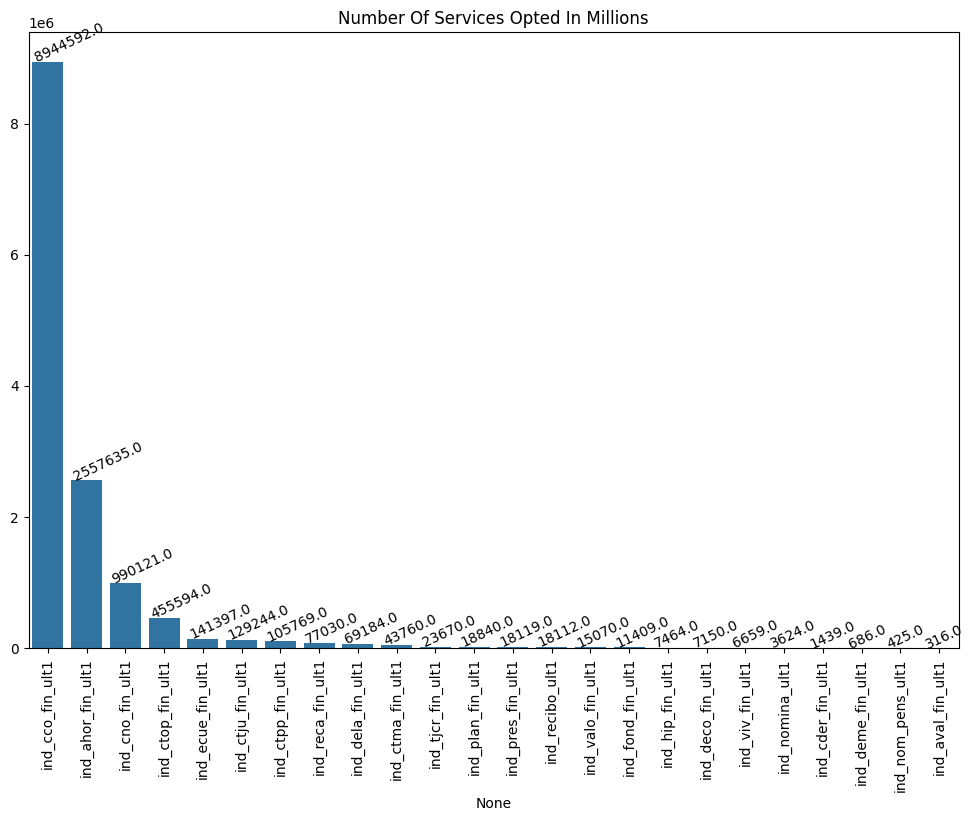

In [13]:
# Checking the value count of the products
plt.figure(figsize=(12,8))

# Get the name and the occurences
names = raw_target.value_counts().index
values = raw_target.value_counts().values

# Plot the plot
ax = sns.barplot(x=names, y=values)

# Set the title
ax.set_title("Number Of Services Opted In Millions")

# Set the xticklabels and rotate
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Label the bars
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x(), p.get_height()), rotation=25)

# Show the plot
plt.show()

## Creating a User-Item interaction matrix( count )

In [13]:
train_data.ncodpers

0           1375586
1           1050611
2           1050612
3           1050613
4           1050614
             ...   
13647304    1166765
13647305    1166764
13647306    1166763
13647307    1166789
13647308    1550586
Name: ncodpers, Length: 13647309, dtype: int64

In [14]:
# Our collaborative recommender system requires a user id, service id, and customer satisfaction rating, count or score. 
# Hence we would have to re-engineer new variable (we will create a customer satisfaction metric(service selection ratio) which can replace rating.)

# Creating a user-item matrix, each entry indicates the number of times service opted by that user
user_item_matrix = pd.crosstab(index=train_data.ncodpers, columns=transformed_target, values=1, aggfunc='sum')

# Filling nan values as 0 as service is not opted
user_item_matrix.fillna(0, inplace=True)

# Print the user-item matrix(Represents Count)
user_item_matrix

col_0,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ncodpers,,,,,,,,,,,,,,,,,,,,,
15889,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15890,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15891,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15892,0.0,0.0,12.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1553686,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1553687,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Having calculated the number of times a user has opted for a service. Then for each user we will divide the count of 
# each service with the total number of services the user has opted throughout his/her banking journey.

# Convert the user_item_matrix to array datatype
uim_arr = np.array(user_item_matrix)

# Iterate through each row(user)
for row,item in tqdm(enumerate(uim_arr)):
    # Iterate through each column(item)
    for column,item_value in enumerate(item):
        # Change the count of service opted to ratio
        uim_arr[row, column] = uim_arr[row, column] / sum(item)
        
# Convert the array to dataframe for better view
user_item_ratio_matrix = pd.DataFrame(uim_arr, columns=user_item_matrix.columns, index=user_item_matrix.index)

# Print the user_item_ratio_matrix(Represents the ratio)
user_item_ratio_matrix

956645it [01:09, 13804.37it/s]


col_0,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ncodpers,,,,,,,,,,,,,,,,,,,,,
15889,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
15890,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
15891,0.5,0.0,0.666667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
15892,0.0,0.0,0.705882,0.0,0.876289,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
15893,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.992218,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1553686,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1553687,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [18]:


# Stack the user_item_ratio_matrix to get all values in single column
user_item_ratio_stacked = user_item_ratio_matrix.stack().to_frame()

# Create column for user id
user_item_ratio_stacked['ncodpers'] = [index[0] for index in user_item_ratio_stacked.index]

# Create column for service_opted
user_item_ratio_stacked['service_opted'] = [index[1] for index in user_item_ratio_stacked.index]

# Reset and drop the index
user_item_ratio_stacked.reset_index(drop=True, inplace=True)

# Print the dataframe
user_item_ratio_stacked

,0,ncodpers,service_opted
0,0.0,15889,0
1,0.0,15889,1
2,1.0,15889,2
3,0.0,15889,3
4,0.0,15889,4
...,...,...,...
22959475,0.0,1553689,19
22959476,0.0,1553689,20
22959477,0.0,1553689,21
22959478,0.0,1553689,22


In [19]:
# Formating our final dataset

# Rename the column 0 to service_selection_ratio
user_item_ratio_stacked.rename(columns={0:"service_selection_ratio"}, inplace=True)

# Arange the column systematicaly for better view
user_item_ratio_stacked = user_item_ratio_stacked[['ncodpers','service_opted', 'service_selection_ratio']]

# Drop all the rows with 0 entries as it means the user has never opted for the service
user_item_ratio_stacked.drop(user_item_ratio_stacked[user_item_ratio_stacked['service_selection_ratio']==0].index, inplace=True)

# Reset the index
user_item_ratio_stacked.reset_index(drop=True, inplace=True)

# Display the final dataframe
user_item_ratio_stacked

,ncodpers,service_opted,service_selection_ratio
0,15889,2,1.000000
1,15890,4,1.000000
2,15891,0,0.500000
3,15891,2,0.666667
4,15892,2,0.705882
...,...,...,...
1100243,1553685,0,1.000000
1100244,1553686,0,1.000000
1100245,1553687,0,1.000000
1100246,1553688,0,1.000000


### The above final dataset suits our use case for application in collaborative filtering technique 

In [19]:
# Encode user_id and item_id
user_encoder = LabelEncoder()
user_item_ratio_stacked['ncodpers'] = user_encoder.fit_transform(user_item_ratio_stacked['ncodpers'])

service_encoder = LabelEncoder()
user_item_ratio_stacked['service_opted'] = service_encoder.fit_transform(user_item_ratio_stacked['service_opted'])

user_item_ratio_stacked.head()

,ncodpers,service_opted,service_selection_ratio
0,0,2,1.000000
1,1,4,1.000000
2,2,0,0.500000
3,2,2,0.666667
4,3,2,0.705882


# Building our recommender system

In [20]:
# Creating surprise processable dataset
# Initialize a surprise reader object
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,1), skip_lines=1)

# Load the data
data = Dataset.load_from_df(user_item_ratio_stacked, reader=reader)


In [39]:
# use gridsearch to find best parametr for our svd model
param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])
print(gs.best_score["mae"])
# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.2167721485449536
0.11256421474060634
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}


In [41]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator["rmse"]
trainset =  data.build_full_trainset()
algo.fit(trainset)

In [63]:
def get_recommendation(uid, model, service_range):    
    recommendations = [(uid, 
                        sid, 
                        le.inverse_transform([sid])[0], 
                        model.predict(uid, sid).est) for sid in range(service_range)]
    # Convert to pandas dataframe
    recommendations = pd.DataFrame(recommendations, columns=['uid', 'sid', 'service_name', 'pred'])
    # Sort by pred
    recommendations.sort_values("pred", ascending=False, inplace=True)
    # Reset index
    recommendations.reset_index(drop=True, inplace=True)

    print(recommendations.head())
    # Return
    return dict(services = list(recommendations.service_name))

In [64]:
get_recommendation(15890.0, algo, 10)

       uid  sid       service_name      pred
0  15890.0    2   ind_cco_fin_ult1  0.968998
1  15890.0    0  ind_ahor_fin_ult1  0.968336
2  15890.0    5  ind_ctju_fin_ult1  0.946394
3  15890.0    7  ind_ctop_fin_ult1  0.923326
4  15890.0    8  ind_ctpp_fin_ult1  0.907350


{'services': ['ind_cco_fin_ult1',
  'ind_ahor_fin_ult1',
  'ind_ctju_fin_ult1',
  'ind_ctop_fin_ult1',
  'ind_ctpp_fin_ult1',
  'ind_ctma_fin_ult1',
  'ind_aval_fin_ult1',
  'ind_cno_fin_ult1',
  'ind_cder_fin_ult1',
  'ind_deco_fin_ult1']}

# The next phase aims to prepare our dataset for a content-based filtering algorithm

In [26]:
# We will start by removing records with no details about the user. This is necessary because for the choice of algorithm we require attributes
# of our users.

# Dropping rows with no useful data
train_data.drop(train_data[train_data['ind_empleado'].isnull()].index, axis=0, inplace=True)

# Dropping rows with no useful data
train_data.drop(train_data[train_data['ind_nomina_ult1'].isnull()].index, axis=0, inplace=True)

# Dropping one-hot encoded columns of services
train_data.drop(columns=train_data.iloc[:1,22:-1].columns, inplace=True)

# Print the dataframe
train_data.head()

AttributeError: 'Trainset' object has no attribute 'drop'

In [ ]:
# Checking the null value for all columns
(train_data.isnull().sum()/len(train_data))*100

fecha_dato                0.000000
ncodpers                  0.000000
ind_empleado              0.000000
pais_residencia           0.000000
sexo                      0.000514
age                       0.000000
fecha_alta                0.000000
ind_nuevo                 0.000000
antiguedad                0.000000
indrel                    0.000000
indrel_1mes               0.896129
tiprel_1mes               0.896129
indresi                   0.000000
indext                    0.000000
canal_entrada             1.162514
indfall                   0.000000
tipodom                   0.000007
cod_prov                  0.483554
nomprov                   0.483554
ind_actividad_cliente     0.000000
renta                    20.313740
segmento                  1.186209
service_opted_for         0.000000
dtype: float64

In [ ]:
# Filling renta with its mean
train_data['renta'].fillna(train_data['renta'].mean(), inplace=True)

# Filling cod_prov with its mode
train_data['cod_prov'].fillna(train_data['cod_prov'].mode()[0], inplace=True)

# Filling indrel_1mes with its mode
train_data['indrel_1mes'].fillna(train_data['indrel_1mes'].mode()[0], inplace=True)

In [ ]:
# Check unique category for all categorical variables
# List of names of columns of type object
obj_cols = train_data.select_dtypes('object')

# Iterate through each column
for col in obj_cols:
    print("*"*5,col,"*"*5)
    # Print its unique value
    print(train_data[col].unique(),"\n\n")

***** fecha_dato *****
['2015-01-28' '2015-02-28' '2015-03-28' '2015-04-28' '2015-05-28'
 '2015-06-28' '2015-07-28' '2015-08-28' '2015-09-28' '2015-10-28'
 '2015-11-28' '2015-12-28' '2016-01-28' '2016-02-28' '2016-03-28'
 '2016-04-28' '2016-05-28'] 


***** ind_empleado *****
['N' 'A' 'B' 'F' 'S'] 


***** pais_residencia *****
['ES' 'CA' 'CH' 'CL' 'IE' 'AT' 'NL' 'FR' 'GB' 'DE' 'DO' 'BE' 'AR' 'VE'
 'US' 'MX' 'BR' 'IT' 'EC' 'PE' 'CO' 'HN' 'FI' 'SE' 'AL' 'PT' 'MZ' 'CN'
 'TW' 'PL' 'IN' 'CR' 'NI' 'HK' 'AD' 'CZ' 'AE' 'MA' 'GR' 'PR' 'RO' 'IL'
 'RU' 'GT' 'GA' 'NO' 'SN' 'MR' 'UA' 'BG' 'PY' 'EE' 'SV' 'ET' 'CM' 'SA'
 'CI' 'QA' 'LU' 'PA' 'BA' 'BO' 'AU' 'BY' 'KE' 'SG' 'HR' 'MD' 'SK' 'TR'
 'AO' 'CU' 'GQ' 'EG' 'ZA' 'DK' 'UY' 'GE' 'TH' 'DZ' 'LB' 'JP' 'NG' 'PK'
 'TN' 'TG' 'KR' 'GH' 'RS' 'VN' 'PH' 'KW' 'NZ' 'MM' 'KH' 'GI' 'SL' 'GN'
 'GW' 'OM' 'CG' 'LV' 'LT' 'ML' 'MK' 'HU' 'IS' 'LY' 'CF' 'GM' 'KZ' 'CD'
 'BZ' 'ZW' 'DJ' 'JM' 'BM' 'MT'] 


***** sexo *****
['H' 'V' nan] 


***** age *****
[' 35' ' 23' ' 22

In [ ]:
# Correcting the categories of column - indrel_1mes
train_data['indrel_1mes'].replace('1', 1, inplace=True)
train_data['indrel_1mes'].replace('1.0', 1, inplace=True)
train_data['indrel_1mes'].replace('2', 2, inplace=True)
train_data['indrel_1mes'].replace('2.0', 2, inplace=True)
train_data['indrel_1mes'].replace('3', 3, inplace=True)
train_data['indrel_1mes'].replace('3.0', 3, inplace=True)
train_data['indrel_1mes'].replace('4', 4, inplace=True)
train_data['indrel_1mes'].replace('4.0', 4, inplace=True)
train_data['indrel_1mes'].replace('P', 5, inplace=True)
train_data['indrel_1mes'].replace('None',np.nan, inplace=True)

# Print dataframe
train_data.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,indext,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,service_opted_for
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,N,KHL,N,1.0,29.0,MALAGA,1.0,87218.100000,02 - PARTICULARES,2
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,S,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.740000,03 - UNIVERSITARIO,2
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,N,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.110000,03 - UNIVERSITARIO,2
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,N,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.540000,03 - UNIVERSITARIO,9
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,N,KHE,N,1.0,50.0,ZARAGOZA,1.0,134253.664457,03 - UNIVERSITARIO,2


## Encoding categorical variables

In [ ]:
# List of columns to encode
cols_to_encode = ['ind_empleado', 'pais_residencia', 'sexo', 'indrel', 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'segmento']

# List of label encoders which will be used for transformations later
label_encoders = []

# Create Label encode these columns iteratively
for col in tqdm(cols_to_encode):
    # Initialize a label encoder object
    lab_enc = LabelEncoder()
    
    # Encode the column and replace it with existing
    train_data[col] = lab_enc.fit_transform(train_data[col])
    
    # Append it in the label_encoders list to use it later
    label_encoders.append(lab_enc)
    
# Print the data
train_data.head()

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,indext,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,service_opted_for
0,2015-01-28,1375586,3,36,0,35,2015-01-12,0.0,6,0,...,0,153,0,1.0,29.0,MALAGA,1.0,87218.100000,1,2
1,2015-01-28,1050611,3,36,1,23,2012-08-10,0.0,35,0,...,1,150,0,1.0,13.0,CIUDAD REAL,0.0,35548.740000,2,2
2,2015-01-28,1050612,3,36,1,23,2012-08-10,0.0,35,0,...,0,150,0,1.0,13.0,CIUDAD REAL,0.0,122179.110000,2,2
3,2015-01-28,1050613,3,36,0,22,2012-08-10,0.0,35,0,...,0,149,0,1.0,50.0,ZARAGOZA,0.0,119775.540000,2,9
4,2015-01-28,1050614,3,36,1,23,2012-08-10,0.0,35,0,...,0,150,0,1.0,50.0,ZARAGOZA,1.0,134253.664457,2,2


In [ ]:
# Deleting column 'nomprov' as we already have its encoded feature(cod_prov)
train_data.drop(columns=['nomprov'], inplace=True)

# Deleting column tipodom as all values are '1'
train_data.drop(columns=['tipodom'], inplace=True)

# Print the dataframe
train_data.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,tiprel_1mes,indresi,indext,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,service_opted_for
0,2015-01-28,1375586,3,36,0,35,2015-01-12,0.0,6,0,...,0,1,0,153,0,29.0,1.0,87218.100000,1,2
1,2015-01-28,1050611,3,36,1,23,2012-08-10,0.0,35,0,...,1,1,1,150,0,13.0,0.0,35548.740000,2,2
2,2015-01-28,1050612,3,36,1,23,2012-08-10,0.0,35,0,...,1,1,0,150,0,13.0,0.0,122179.110000,2,2
3,2015-01-28,1050613,3,36,0,22,2012-08-10,0.0,35,0,...,1,1,0,149,0,50.0,0.0,119775.540000,2,9
4,2015-01-28,1050614,3,36,1,23,2012-08-10,0.0,35,0,...,0,1,0,150,0,50.0,1.0,134253.664457,2,2


## Choosing recent transaction for each user

In [ ]:
# Selecting non-duplicate rows(unique) and saving the latest transaction by giving parameter keep='last'
user_data = train_data[train_data['ncodpers'].duplicated(keep='last')]

# Reset the index
user_data.reset_index(drop=True, inplace=True)

# Print the head
user_data.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,tiprel_1mes,indresi,indext,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,service_opted_for
0,2015-01-28,1375586,3,36,0,35,2015-01-12,0.0,6,0,...,0,1,0,153,0,29.0,1.0,87218.100000,1,2
1,2015-01-28,1050611,3,36,1,23,2012-08-10,0.0,35,0,...,1,1,1,150,0,13.0,0.0,35548.740000,2,2
2,2015-01-28,1050612,3,36,1,23,2012-08-10,0.0,35,0,...,1,1,0,150,0,13.0,0.0,122179.110000,2,2
3,2015-01-28,1050613,3,36,0,22,2012-08-10,0.0,35,0,...,1,1,0,149,0,50.0,0.0,119775.540000,2,9
4,2015-01-28,1050614,3,36,1,23,2012-08-10,0.0,35,0,...,0,1,0,150,0,50.0,1.0,134253.664457,2,2


## TO BE CONTINUED